# Traffic Signs Recognition using CNN

In [72]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf

import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# from keras.models import Sequential, load_model
# from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras import layers, models
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from china.china_dataset_reader import load_traffic_sign_dataset
from india.india_dataset_reader import load_india_dataset


## GTSRB Dataset Overview

In [73]:
# Train.csv
train_csv_path = os.getcwd() + "\dataset\Train.csv"
train_df = pd.read_csv(train_csv_path, usecols=['ClassId', 'Path', 'Width', 'Height'])
train_df.head()

,Width,Height,ClassId,Path
0,27,26,20,Train/20/00020_00000_00000.png
1,28,27,20,Train/20/00020_00000_00001.png
2,29,26,20,Train/20/00020_00000_00002.png
3,28,27,20,Train/20/00020_00000_00003.png
4,28,26,20,Train/20/00020_00000_00004.png


code reference:

https://github.com/deepak2233/Traffic-Signs-Recognition-using-CNN-Keras/blob/main/Model/Traffic%20Signs%20Recognition%20using%20CNN%20%26%20Keras%20with%2098%25%20Accuracy.ipynb

https://www.kaggle.com/code/osamaabidoo/98-accuracy-on-german-traffic-sign-recognition

In [74]:
# Test.csv
test_csv_path = os.getcwd() + "\dataset\Test.csv"
test_df = pd.read_csv(test_csv_path, usecols=['ClassId', 'Path', 'Width', 'Height'])
test_df.head()

,Width,Height,ClassId,Path
0,53,54,16,Test/00000.png
1,42,45,1,Test/00001.png
2,48,52,38,Test/00002.png
3,27,29,33,Test/00003.png
4,60,57,11,Test/00004.png


In [75]:
# GTSRB Label Overview (from Kaggle)
GTSRB_classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Load the GTSRB


In [76]:
train_data = [] # X_train
train_labels = [] # X_test
classes = 43
train_path = os.getcwd() + "\dataset\Train"

for i in os.listdir(train_path):
    dir = train_path + '/' + i
    if os.path.isdir(dir):
        for j in os.listdir(dir):
            try:
                img_path = dir+ '/' +j
                img = cv2.imread(img_path,-1)
                # resize all images to 30,30
                img = cv2.resize(img, (30,30), interpolation = cv2.INTER_NEAREST)
                train_data.append(img)
                train_labels.append(i)
            except Exception as e:
                print(e)    
train_data = np.array(train_data)
train_labels = np.array(train_labels)
print(train_data.shape, train_labels.shape)

(39209, 30, 30, 3) (39209,)


In [77]:
test_data = [] # y_train
test_labels = [] # y_test
test_path = os.getcwd() + "\dataset\Test"

for index, row in test_df.iterrows():
    img_path = os.getcwd() + "\dataset/" + row['Path']
    img = cv2.imread(img_path, -1)
    img = cv2.resize(img, (30,30), interpolation=cv2.INTER_NEAREST)
    test_data.append(img)
    test_labels.append(row['ClassId'])

test_data = np.array(test_data)
test_labels = np.array(test_labels)
print(test_data.shape, test_labels.shape)

(12630, 30, 30, 3) (12630,)


## Visualize Train Data in GTSRB

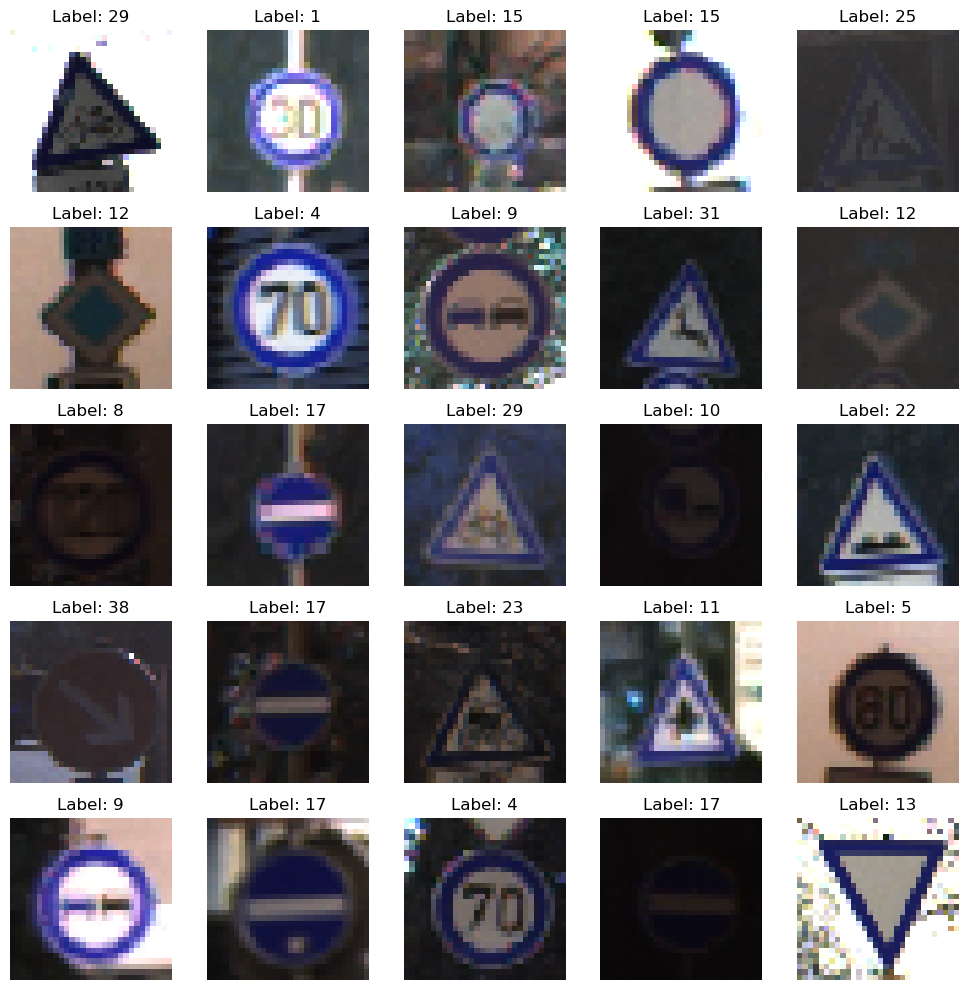

In [42]:
random_indices = random.sample(range(len(train_data)), 25)
# randomly plot 25 images from train_data[]
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        index = random_indices[i * 5 + j]
        # Display the image
        axs[i, j].imshow(train_data[index])
        axs[i, j].axis('off')
        # Display the corresponding label
        axs[i, j].set_title(f"Label: {train_labels[index]}")
plt.tight_layout()
plt.show()


## Load Chinese Traffic Sign Dataset

In [78]:
china_images, china_categories = load_traffic_sign_dataset()
print(china_images.shape, china_categories.shape)

CSV Path: G:\COMP9444\dataset\comp9444-project\china\annotations.csv
(6164, 30, 30, 3) (6164,)


## Data augmentation functions

In [79]:
# rotates each image by -10 degrees (left) and 10 degrees (right) and then concatenates 
# the original and augmented datasets along with their corresponding labels. 
def rotate_augmentation(images, labels):
    augmented_data = []
    augmented_labels = []

    for img, label in zip(images, labels):
        # Rotate left
        rotated_left = rotate_image(img, angle=-10)
        augmented_data.append(rotated_left)
        augmented_labels.append(label)

        # Rotate right
        rotated_right = rotate_image(img, angle=10)
        augmented_data.append(rotated_right)
        augmented_labels.append(label)

    augmented_data = np.concatenate([images, augmented_data])
    augmented_labels = np.concatenate([labels, augmented_labels])

    return augmented_data, augmented_labels

def rotate_image(image, angle):
    center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_NEAREST)
    return rotated_image

china_images, china_categories= rotate_augmentation(china_images, china_categories)
print(china_images.shape, china_categories.shape)

(18492, 30, 30, 3) (18492,)


In [80]:
# applies random zooming (by 0.15) or width shifting (by 0.1) or height shifting (by 0.1) to each image and then concatenates 
# the original and augmented datasets along with their corresponding labels. 
def random_zoom_or_shift(images, labels):
    augmented_data = []
    augmented_labels = []

    for img, label in zip(images, labels):
        # Randomly choose augmentations types
        num_augmentations = np.random.randint(1, 4)  # Choose between 1 to 3 augmentations
        augmentation_types = np.random.choice(['zoom', 'width_shift', 'height_shift'], size=num_augmentations, replace=True)
        augmented_img = img.copy()
        for augmentation_type in augmentation_types:
            if augmentation_type == 'zoom':
                zoom_factor = np.random.uniform(1 - 0.15, 1 + 0.15)
                augmented_img = zoom_image(augmented_img, zoom_factor)
            elif augmentation_type == 'width_shift':
                width_shift_factor = np.random.uniform(-0.1, 0.1)
                augmented_img = shift_width(augmented_img, width_shift_factor)
            elif augmentation_type == 'height_shift':
                height_shift_factor = np.random.uniform(-0.1, 0.1)
                augmented_img = shift_height(augmented_img, height_shift_factor)
        augmented_img = cv2.resize(augmented_img, (30, 30), interpolation=cv2.INTER_NEAREST)
        augmented_data.append(augmented_img)
        augmented_labels.append(label)       

    augmented_data = np.concatenate([images, augmented_data])
    augmented_labels = np.concatenate([labels, augmented_labels])

    return augmented_data, augmented_labels

def zoom_image(image, factor):
    height, width = image.shape[:2]
    new_height, new_width = int(height * factor), int(width * factor)
    zoomed_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
    return zoomed_image

def shift_width(image, factor):
    height, width = image.shape[:2]
    shift_pixels = int(width * factor)
    shifted_image = np.roll(image, shift_pixels, axis=1)
    return shifted_image

def shift_height(image, factor):
    height, width = image.shape[:2]
    shift_pixels = int(height * factor)
    shifted_image = np.roll(image, shift_pixels, axis=0)
    return shifted_image


china_images, china_categories = random_zoom_or_shift(china_images, china_categories)
print(china_images.shape, china_categories.shape)


(36984, 30, 30, 3) (36984,)


## Split China dataset to Train and Test set

In [81]:
china_train_data, china_test_data, china_train_label, china_test_label = train_test_split(china_images, china_categories, test_size=0.25, random_state=42)

# Print the shapes of the resulting sets
print("china_train_data shape:", china_train_data.shape)
print("china_test_data shape:", china_test_data.shape)
print("china_train_label shape:", china_train_label.shape)
print("china_test_label shape:", china_test_label.shape)

china_train_data shape: (27738, 30, 30, 3)
china_test_data shape: (9246, 30, 30, 3)
china_train_label shape: (27738,)
china_test_label shape: (9246,)


In [82]:
# def plot_classes_with_images(images, categories, num_classes=5, images_per_row=7):
#     unique_categories = np.unique(categories)
#     num_rows = -(-num_classes // images_per_row)  # Ceil division to calculate the number of rows

#     fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, num_rows * 4))

#     for i in range(num_rows):
#         for j in range(images_per_row):
#             index = i * images_per_row + j
#             if index < num_classes:
#                 class_category = unique_categories[index]
#                 class_images = images[categories == class_category]

#                 # Randomly select an image from the class
#                 random_image = random.choice(class_images)

#                 axes[i, j].imshow(random_image)
#                 axes[i, j].set_title(f'Class {class_category}')
#                 axes[i, j].axis('off')
#             else:
#                 axes[i, j].axis('off')  # Hide empty subplots

#     plt.show()


In [83]:
# plot_classes_with_images(china_images, china_categories, 58)

In [84]:
# plot_classes_with_images(train_data, train_labels, 43)

In [85]:
# manually label the classes in chinese dataset
# labelled based on the name on https://en.wikipedia.org/wiki/Road_signs_in_China
china_classes = { 0:'Speed limit (5km/h)',
                1:'Speed limit (15km/h)', 
                2:'Speed limit (30km/h)', 
                3:'Speed limit (40km/h)', 
                4:'Speed limit (50km/h)', 
                5:'Speed limit (60km/h)', 
                6:'Speed limit (70km/h)', 
                7:'Speed limit (80km/h)', 
                8:'No proceed straight and left turns', 
                9:'No proceed straight and right turns', 
                10:'No proceed straight', 
                11:'No left turn', 
                12:'No left and right turns', 
                13:'No right turn', 
                14:'No overtaking', 
                15:'No U-turns', 
                16:'No motor vehicles', 
                17:'No honking', 
                18:'End of speed limit (40km/h)', 
                19:'End of speed limit (50km/h)', 
                20:'Go straight or right', 
                21:'Ahead only', 
                22:'Turn left ahead', 
                23:'Go left or right', 
                24:'Turn right ahead', 
                25:'Keep left', 
                26:'Keep right', 
                27:'Roundabout mandatory', 
                28:'Lane for automobile', 
                29:'Honking', 
                30:'Bicycles only',
                31:'U-turn', 
                32:'Turn left and/or right to detour', 
                33:'Traffic signals', 
                34:'General caution', 
                35:'Pedestrian crossing ahead', 
                36:'Bicycles crossing', 
                37:'Children crossing', 
                38:'Dangerous curve right', 
                39:'Dangerous curve left', 
                40:'Steep descent', 
                41:'Steep ascent', 
                42:'Tunnel ahead', # not sure
                43:'Side road junction ahead on the right',
                44:'Side road junction ahead on the left',
                45:'Cross-village road',
                46:'Double curve, with turn right first, then left', # GTSRB has a general version double curve, should i merge them?
                47:'Railroad crossing ahead (without safety barriers)',
                48:'Road work',
                49:'Multiple curves',
                50:'Railroad head (with safety barriers)',
                51:'Accident area',
                52:'Stop',
                53:'No vehicles',
                54:'No stopping',
                55:'No entry',
                56:'Yield',
                57:'Control' }

## Merge GTRSB and Chinese dataset

In [86]:
# helper function to merge two classes dict together
def merge_classes(classes1, classes2):
    merged_classes = {}
    used_values = set()

    for key1, value1 in classes1.items():
        if value1.lower() not in used_values:
            merged_classes[key1] = value1
            used_values.add(value1.lower())

    for key2, value2 in classes2.items():
        if value2.lower() not in used_values:
            merged_classes[max(merged_classes.keys()) + 1] = value2
            used_values.add(value2.lower())

    return merged_classes

In [87]:
# function to merge two dataset together 
def merge_datasets(dataset1_data, dataset1_labels, dataset1_classes, dataset2_data, dataset2_labels, dataset2_classes):
    merged_data = []
    merged_labels = []
    
    class_mapping = merge_classes(dataset1_classes, dataset2_classes)
    
    def find_key_by_value(dict, target_value):
        for key, value in dict.items():
            if value.lower() == target_value.lower():
                return key

    # Merge the datasets based on class mapping
    for data, label in zip(dataset1_data, dataset1_labels):
        value = dataset1_classes.get(int(label))
        new_key = find_key_by_value(class_mapping, value)
        merged_labels.append(new_key)
        merged_data.append(data)

    for data, label in zip(dataset2_data, dataset2_labels):
        value = dataset2_classes.get(int(label))
        new_key = find_key_by_value(class_mapping, value)
        merged_labels.append(new_key)
        merged_data.append(data)

    return np.array(merged_data), np.array(merged_labels), class_mapping


# merge GTRSB train and test data back together
# GTRSB_data = np.concatenate([train_data, test_data], axis=0)
# GTRSB_labels = np.concatenate([train_labels, test_labels], axis=0)
GTRSB_data = train_data
GTRSB_labels = train_labels
china_images = china_train_data
china_categories = china_train_label
# merge GTRSB and Chinese dataset
merged_data, merged_labels, merged_class_mapping = merge_datasets(GTRSB_data, GTRSB_labels, GTSRB_classes, china_images, china_categories, china_classes)
print("GTRSB Dataset Shapes:")
print(GTRSB_data.shape, GTRSB_labels.shape)
print("China Dataset Shapes:")
print(china_images.shape, china_categories.shape)
# Display the merged dataset shapes
print("Merged Dataset Shapes:")
print("Merged Data Shape:", merged_data.shape)
print("Merged Labels Shape:", merged_labels.shape)

# Display the class mapping after merging
print("Class Mapping After Merging:")
for key, value in merged_class_mapping.items():
    print(f"{key}: {value}")

GTRSB Dataset Shapes:
(39209, 30, 30, 3) (39209,)
China Dataset Shapes:
(27738, 30, 30, 3) (27738,)
Merged Dataset Shapes:
Merged Data Shape: (66947, 30, 30, 3)
Merged Labels Shape: (66947,)
Class Mapping After Merging:
0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit (80km/h)
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing veh over 3.5 tons
11: Right-of-way at intersection
12: Priority road
13: Yield
14: Stop
15: No vehicles
16: Veh > 3.5 tons prohibited
17: No entry
18: General caution
19: Dangerous curve left
20: Dangerous curve right
21: Double curve
22: Bumpy road
23: Slippery road
24: Road narrows on the right
25: Road work
26: Traffic signals
27: Pedestrians
28: Children crossing
29: Bicycles crossing
30: Beware of ice/snow
31: Wild animals crossing
32: End speed + passing limits
33: Turn right ahead
34: Turn left ahead
35: Ahead onl

In [88]:
# plot_classes_with_images(merged_data, merged_labels, 78)

## Load the India Dataset 

In [89]:
India_train, India_label = load_india_dataset()
print(India_train.shape, India_label.shape)

(10584, 30, 30, 3) (10584,)


In [90]:
# Increase ths size of the dataset by using data augmentation again like the chinese dataset
India_train, India_label= rotate_augmentation(India_train, India_label)
India_train, India_label = random_zoom_or_shift(India_train, India_label)
print(India_train.shape, India_label.shape)

(63504, 30, 30, 3) (63504,)


In [91]:
# Split the dataset
india_train_data, india_test_data, india_train_label, india_test_label = train_test_split(India_train, India_label, test_size=0.25, random_state=42)

# Print the shapes of the resulting sets
print("india_train_data shape:", india_train_data.shape)
print("india_test_data shape:", india_test_data.shape)
print("india_train_label shape:", india_train_label.shape)
print("india_test_label shape:", india_test_label.shape)

india_train_data shape: (47628, 30, 30, 3)
india_test_data shape: (15876, 30, 30, 3)
india_train_label shape: (47628,)
india_test_label shape: (15876,)


In [92]:
# manually label 
india_classes = {
      0:'Yield',
      1:'No proceed straight',
      2:'One-way traffic',
      3:'One-way traffic',
      4:'No vehicles in both directions',
      5:'No entry for cycles',
      6:'No entry for goods vehicles',
      7:'No entry for pedestrians',
      8:'No entry for bullock carts',
      9:'No entry for hand carts',
      10:'No motor vehicles',
      11:'Height limit',
      12:'Weight limit',
      13:'Axle weight limit',
      14:'Length limit',
      15:'No left turn',
      16:'No right turn',
      17:'No overtaking',
      18:'Speed limit (90 km/h)',
      19:'Speed limit (110 km/h)',
      20:'No honking',
      21:'No parking',
      22:'No stopping',
      23:'Turn left ahead',
      24:'Turn right ahead',
      25:'Steep descent',
      26:'Steep ascent',
      27:'Road narrows on the right',
      28:'Narrow bridge',
      29:'Unprotected quay',
      30:'Road hump',
      31:'Bumpy road',
      32:'Loose gravel',
      33:'Falling rocks',
      34:'Wild animals crossing',
      35:'Crossroads',
      36:'Side road junction',
      37:'Oblique side road junction',
      38:'T-junction',
      39:'Y-junction',
      40:'Staggered side road junction',
      41:'Roundabout mandatory',
      42:'Railroad head (with safety barriers)',
      43:'Unguarded level crossing ahead',
      44:'Parking',
      45:'Bus stop'
}

## Merge dataset (GTRSB + China + India)

In [42]:
merged_data, merged_labels, merged_class_mapping = merge_datasets(merged_data, merged_labels, merged_class_mapping, india_train_data, india_train_label, india_classes)
# Display the merged dataset shapes
print("Merged Dataset Shapes:")
print("Merged Data Shape:", merged_data.shape)
print("Merged Labels Shape:", merged_labels.shape)

# Display the class mapping after merging
print("Class Mapping After Merging:")
for key, value in merged_class_mapping.items():
    print(f"{key}: {value}")

Merged Dataset Shapes:
Merged Data Shape: (107640, 30, 30, 3)
Merged Labels Shape: (107640,)
Class Mapping After Merging:
0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit (80km/h)
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing veh over 3.5 tons
11: Right-of-way at intersection
12: Priority road
13: Yield
14: Stop
15: No vehicles
16: Veh > 3.5 tons prohibited
17: No entry
18: General caution
19: Dangerous curve left
20: Dangerous curve right
21: Double curve
22: Bumpy road
23: Slippery road
24: Road narrows on the right
25: Road work
26: Traffic signals
27: Pedestrians
28: Children crossing
29: Bicycles crossing
30: Beware of ice/snow
31: Wild animals crossing
32: End speed + passing limits
33: Turn right ahead
34: Turn left ahead
35: Ahead only
36: Go straight or right
37: Go straight or left
38: Keep right
39: Keep left
40: Roundabout man

## Split Data Overview

In [43]:
# Training set
print("GTRSB Train data and label shape:")
print(GTRSB_data.shape, GTRSB_labels.shape) 
print("China Train data and label shape:")
print(china_train_data.shape, china_train_label.shape)
print("India Train data and label shape:")
print(india_train_data.shape, india_train_label.shape)
print("Merged Train shape:")
print(merged_data.shape, merged_labels.shape)
print()
test_labels = np.squeeze(test_labels)
# Testing set
print("GTRSB Test data and label shape:")
print(test_data.shape, test_labels.shape) 
print("China Test data and label shape:")
print(china_test_data.shape, china_test_label.shape)
print("India Test data and label shape:")
print(india_test_data.shape, india_test_label.shape)
# create an overall testset 
overall_test_data, overall_test_labels, overall_classes = merge_datasets(test_data, test_labels, GTSRB_classes, china_test_data, china_test_label, china_classes)
overall_test_data, overall_test_labels, overall_classes = merge_datasets(overall_test_data, overall_test_labels, overall_classes, india_test_data, india_test_label, india_classes)

print("Overall Test data and label shape:")
print(overall_test_data.shape, overall_test_labels.shape)

GTRSB Train data and label shape:
(39209, 30, 30, 3) (39209,)
China Train data and label shape:
(20803, 30, 30, 3) (20803,)
India Train data and label shape:
(47628, 30, 30, 3) (47628,)
Merged Train shape:
(107640, 30, 30, 3) (107640,)

GTRSB Test data and label shape:
(12630, 30, 30, 3) (12630,)
China Test data and label shape:
(6935, 30, 30, 3) (6935,)
India Test data and label shape:
(15876, 30, 30, 3) (15876,)
Overall Test data and label shape:
(35441, 30, 30, 3) (35441,)


In [44]:
# normalize images
merged_data = merged_data / 255.0 # Train data
overall_test_data = overall_test_data / 255.0
test_data = test_data / 255.0 # GTRSB only test set
china_test_data = china_test_data / 255.0
india_test_data = india_test_data / 255.0

In [45]:
# Converting labels into one hot encoding 
# train_labels = to_categorical(train_labels, 43)
# test_labels = to_categorical(test_labels, 43)
merged_labels = to_categorical(merged_labels, 106) # Train labels
overall_test_labels = to_categorical(overall_test_labels, 106)


In [46]:
# Normalize pixel values to be between 0 and 1
# train_data = train_data / 255.0
# will modify the splitting latter to create train and test set
# Split the data into training and validation sets (80%, 20%)
X_train, X_val, y_train, y_val = train_test_split(merged_data, merged_labels, test_size=0.2, random_state=42)

In [47]:
# first attempt, please modify 
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Layer
from tensorflow.keras.models import Model

def resnet_identity_block(x, filters, kernel_size):
    """A ResNet identity block with two Conv2D layers."""
    fx = Conv2D(filters, kernel_size, padding='same')(x)
    fx = BatchNormalization()(fx)
    fx = Activation('relu')(fx)

    fx = Conv2D(filters, kernel_size, padding='same')(fx)
    fx = BatchNormalization()(fx)

    out = Add()([x, fx])  # Add() layer creates a residual connection
    out = Activation('relu')(out)
    return out

def resnet_conv_block(x, filters, kernel_size, strides):
    """A ResNet convolutional block with a Conv2D shortcut."""
    fx = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    fx = BatchNormalization()(fx)
    fx = Activation('relu')(fx)

    fx = Conv2D(filters, kernel_size, padding='same')(fx)
    fx = BatchNormalization()(fx)

    shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(x)
    shortcut = BatchNormalization()(shortcut)

    out = Add()([fx, shortcut])  # Shortcut connection
    out = Activation('relu')(out)
    return out

# Input layer
input_shape = (30, 30, 3)
inputs = Input(shape=input_shape)

# Initial Conv2D layer
x = Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)

# Residual blocks
x = resnet_conv_block(x, 64, (3, 3), strides=(1, 1))
x = resnet_identity_block(x, 64, (3, 3))
x = MaxPooling2D((2, 2))(x)

x = resnet_conv_block(x, 128, (3, 3), strides=(1, 1))
x = resnet_identity_block(x, 128, (3, 3))

# Finishing layers
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(106, activation='softmax')(x)  # Adjust the number of classes

# Create the model
model = Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 30, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 30, 30, 32)           896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 15, 15, 64)           18496     ['max_pooling2d[0][0]']   

                                                                                                  
 activation_6 (Activation)   (None, 7, 7, 128)            0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 7, 7, 128)            147584    ['activation_6[0][0]']        
                                                                                                  
 batch_normalization_9 (Bat  (None, 7, 7, 128)            512       ['conv2d_10[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 add_3 (Add)                 (None, 7, 7, 128)            0         ['activation_5[0][0]',        
          

In [48]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [70]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
model.save("traffic_sign_model")

Epoch 1/10
2865/2865 [==============================] - 181s 62ms/step - loss: 1.0103 - accuracy: 0.7014 - val_loss: 0.9686 - val_accuracy: 0.7346
Epoch 2/10
2865/2865 [==============================] - 178s 62ms/step - loss: 0.2647 - accuracy: 0.9138 - val_loss: 0.3460 - val_accuracy: 0.8861
Epoch 3/10
2865/2865 [==============================] - 179s 63ms/step - loss: 0.1823 - accuracy: 0.9410 - val_loss: 0.4048 - val_accuracy: 0.8820
Epoch 4/10
2865/2865 [==============================] - 179s 63ms/step - loss: 0.1438 - accuracy: 0.9526 - val_loss: 0.2235 - val_accuracy: 0.9277
Epoch 5/10
2865/2865 [==============================] - 181s 63ms/step - loss: 0.1238 - accuracy: 0.9599 - val_loss: 0.1951 - val_accuracy: 0.9415
Epoch 6/10
2865/2865 [==============================] - 180s 63ms/step - loss: 0.1091 - accuracy: 0.9646 - val_loss: 0.3044 - val_accuracy: 0.9174
Epoch 7/10
2865/2865 [==============================] - 180s 63ms/step - loss: 0.0976 - accuracy: 0.9681 - val_loss: 0

INFO:tensorflow:Assets written to: traffic_sign_model\assets


In [49]:
# plotting graphs for accuracy 
# https://github.com/deepak2233/Traffic-Signs-Recognition-using-CNN-Keras/blob/main/Model/Traffic%20Signs%20Recognition%20using%20CNN%20%26%20Keras%20with%2098%25%20Accuracy.ipynb
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Loss 
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

## Evaluation

Overall test using merged test data:

In [53]:
def plot_confusion_matrix(y_true, y_pred, num_classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    classes = [str(i) for i in range(num_classes)]
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(num_classes, num_classes))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def print_metrics(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=1))


In [54]:
# evaluate on overall test set
model = models.load_model("traffic_sign_model")
y_pred = model.predict(overall_test_data)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(overall_test_labels, axis=1)
print_metrics(y_true, y_pred)
print("Confusion Matrix:")
plot_confusion_matrix(y_true, y_pred, 106, title='Overall')

1108/1108 [==============================] - 24s 22ms/step
Accuracy: 0.9475466267881831
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91        60
           1       0.96      0.99      0.97       892
           2       1.00      0.96      0.98       950
           3       0.96      0.95      0.95       679
           4       0.99      0.96      0.98       793
           5       0.92      0.96      0.94       880
           6       0.97      0.94      0.95       150
           7       0.99      0.83      0.90       450
           8       0.86      1.00      0.92       450
           9       0.97      1.00      0.99       480
          10       1.00      0.97      0.99       660
          11       0.97      0.99      0.98       420
          12       0.99      0.98      0.98       690
          13       1.00      0.99      0.99      1176
          14       1.00      0.98      0.99       339
          15       0.99

Evaluate using GTSRB only test data:

In [70]:
def remap_labels(labels, current_class_mapping, target_class_mapping):
    remapped_labels = []

    for label in labels:
        original_value = current_class_mapping.get(label, None)
        if original_value is not None:
            original_key = next((key for key, value in target_class_mapping.items() if value.lower() == original_value.lower()), None)
            if original_key is not None:
                remapped_labels.append(original_key)
            else:
                remapped_labels.append(-1)
        else:
            remapped_labels.append(-1)

    return remapped_labels




def map_output_to_target_classes(y_pred, target_classes_mapping):
    # Create a reverse mapping for the target classes
    reverse_target_mapping = {v: k for k, v in target_classes_mapping.items()}

    # Map the output to target classes
    y_pred_target_classes = [reverse_target_mapping[label] for label in y_pred]

    return y_pred_target_classes

In [96]:
# remap GTRSB test labels to match the 106 classes label format
test_labels = remap_labels(test_labels, GTSRB_classes, merged_class_mapping)
test_labels = to_categorical(test_labels, 106)

In [69]:
# evaluate on GTRSB only
model = models.load_model("traffic_sign_model")
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
print(len(np.unique(y_true)))
print_metrics(y_true, y_pred)

395/395 [==============================] - 9s 21ms/step
43
Accuracy: 0.9568487727632621
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92        60
           1       0.98      0.99      0.98       720
           2       1.00      0.97      0.98       750
           3       0.96      0.94      0.95       450
           4       1.00      0.96      0.98       660
           5       0.91      0.96      0.93       630
           6       0.97      0.94      0.96       150
           7       0.99      0.83      0.90       450
           8       0.87      1.00      0.93       450
           9       0.98      1.00      0.99       480
          10       1.00      0.97      0.99       660
          11       0.97      0.99      0.98       420
          12       0.99      0.98      0.99       690
          13       1.00      0.99      1.00       720
          14       1.00      0.98      0.99       270
          15       1.00

Confusion Matrix:


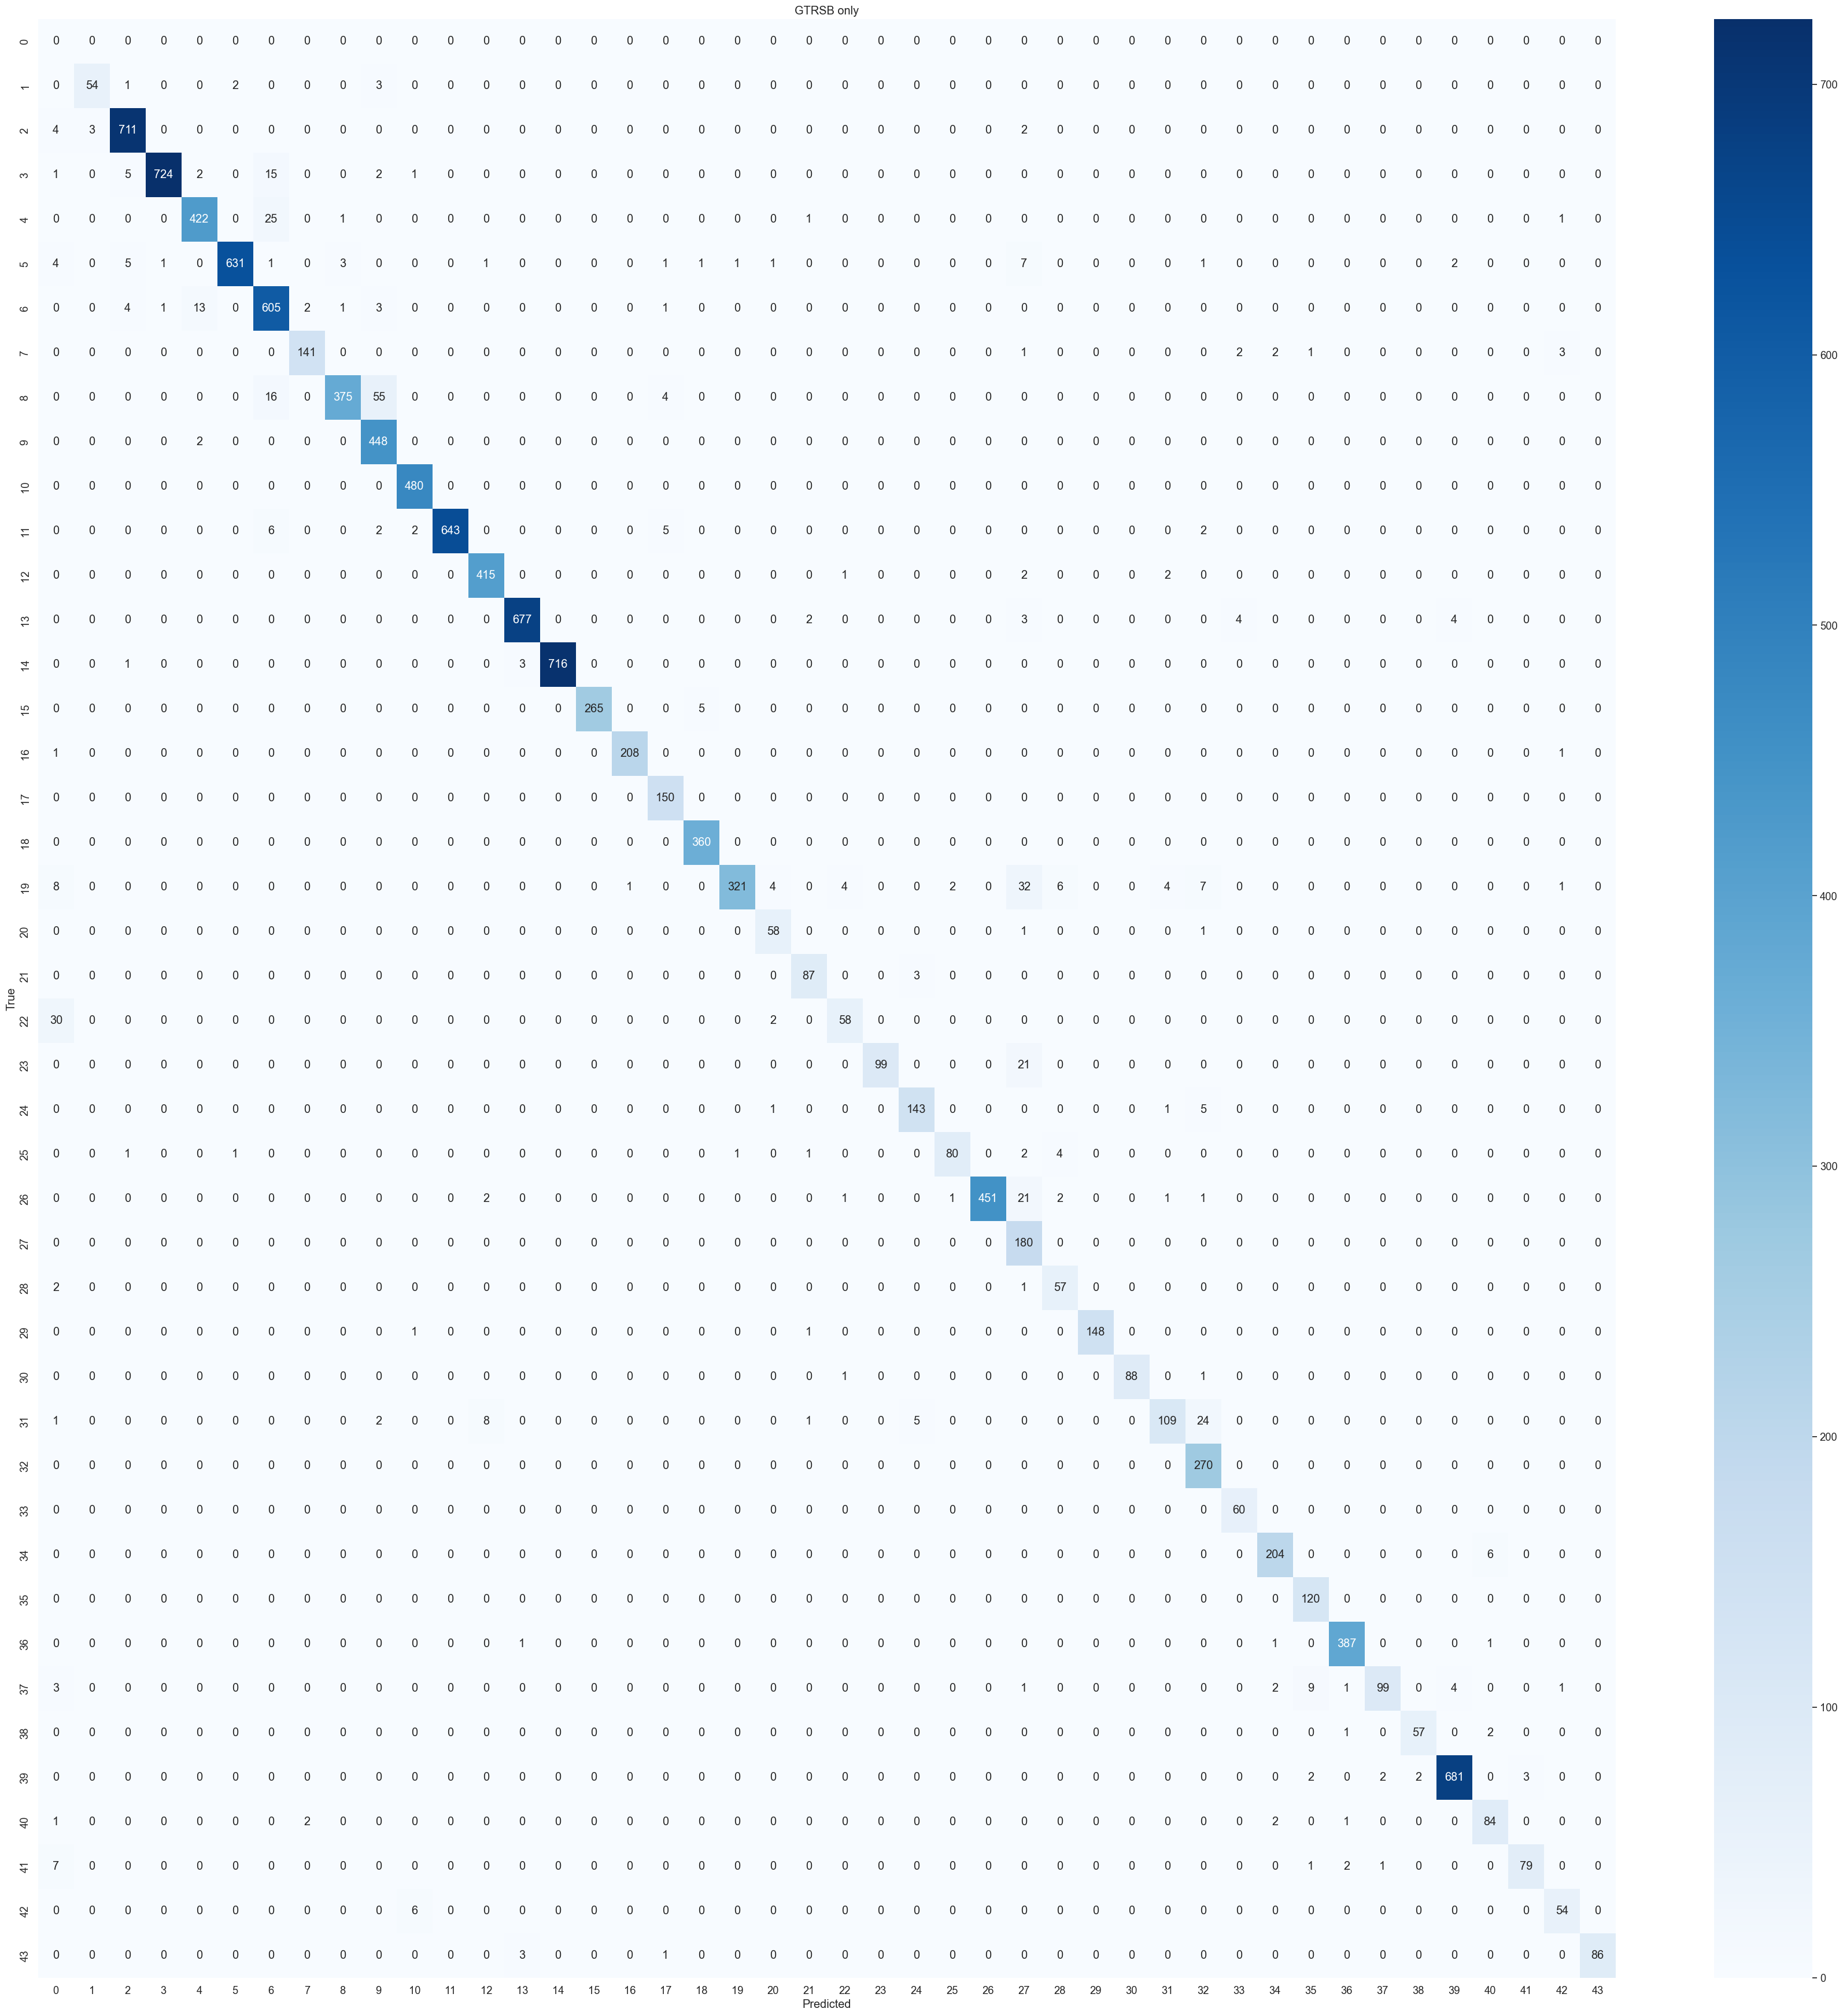

In [58]:
# *Have problem with printing confusion matrix correctly, when remapping the model output labels back to a smaller subset of labels such as GTRSB 43 classes label
# remap to print confusion matrix
y_pred_43 = remap_labels(y_pred, merged_class_mapping, GTSRB_classes)
y_true_43 = remap_labels(y_true, merged_class_mapping, GTSRB_classes)
print("Confusion Matrix:")
plot_confusion_matrix(y_true_43, y_pred_43, 44, title='GTRSB only')

Evaluate using China only test set:

In [59]:
china_test_label = remap_labels(china_test_label, china_classes, merged_class_mapping)
china_test_label = to_categorical(china_test_label, 106)

In [60]:
model = models.load_model("traffic_sign_model")
y_pred = model.predict(china_test_data)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(china_test_label, axis=1)
print(len(np.unique(y_true)))
print_metrics(y_true, y_pred)

217/217 [==============================] - 5s 22ms/step
58
Accuracy: 0.9741888968997837
Classification Report:
               precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       0.89      0.98      0.93       172
           2       1.00      0.93      0.96       200
           3       0.96      0.97      0.96       229
           4       0.97      0.99      0.98       133
           5       0.96      0.96      0.96       250
           6       0.00      1.00      0.00         0
           8       0.00      1.00      0.00         0
           9       0.00      1.00      0.00         0
          10       0.00      1.00      0.00         0
          12       0.00      1.00      0.00         0
          13       0.99      1.00      1.00       170
          14       1.00      0.99      0.99        69
          15       0.67      1.00      0.80         2
          17       1.00      1.00      1.00       293
          18       0.86

Confusion Matrix:


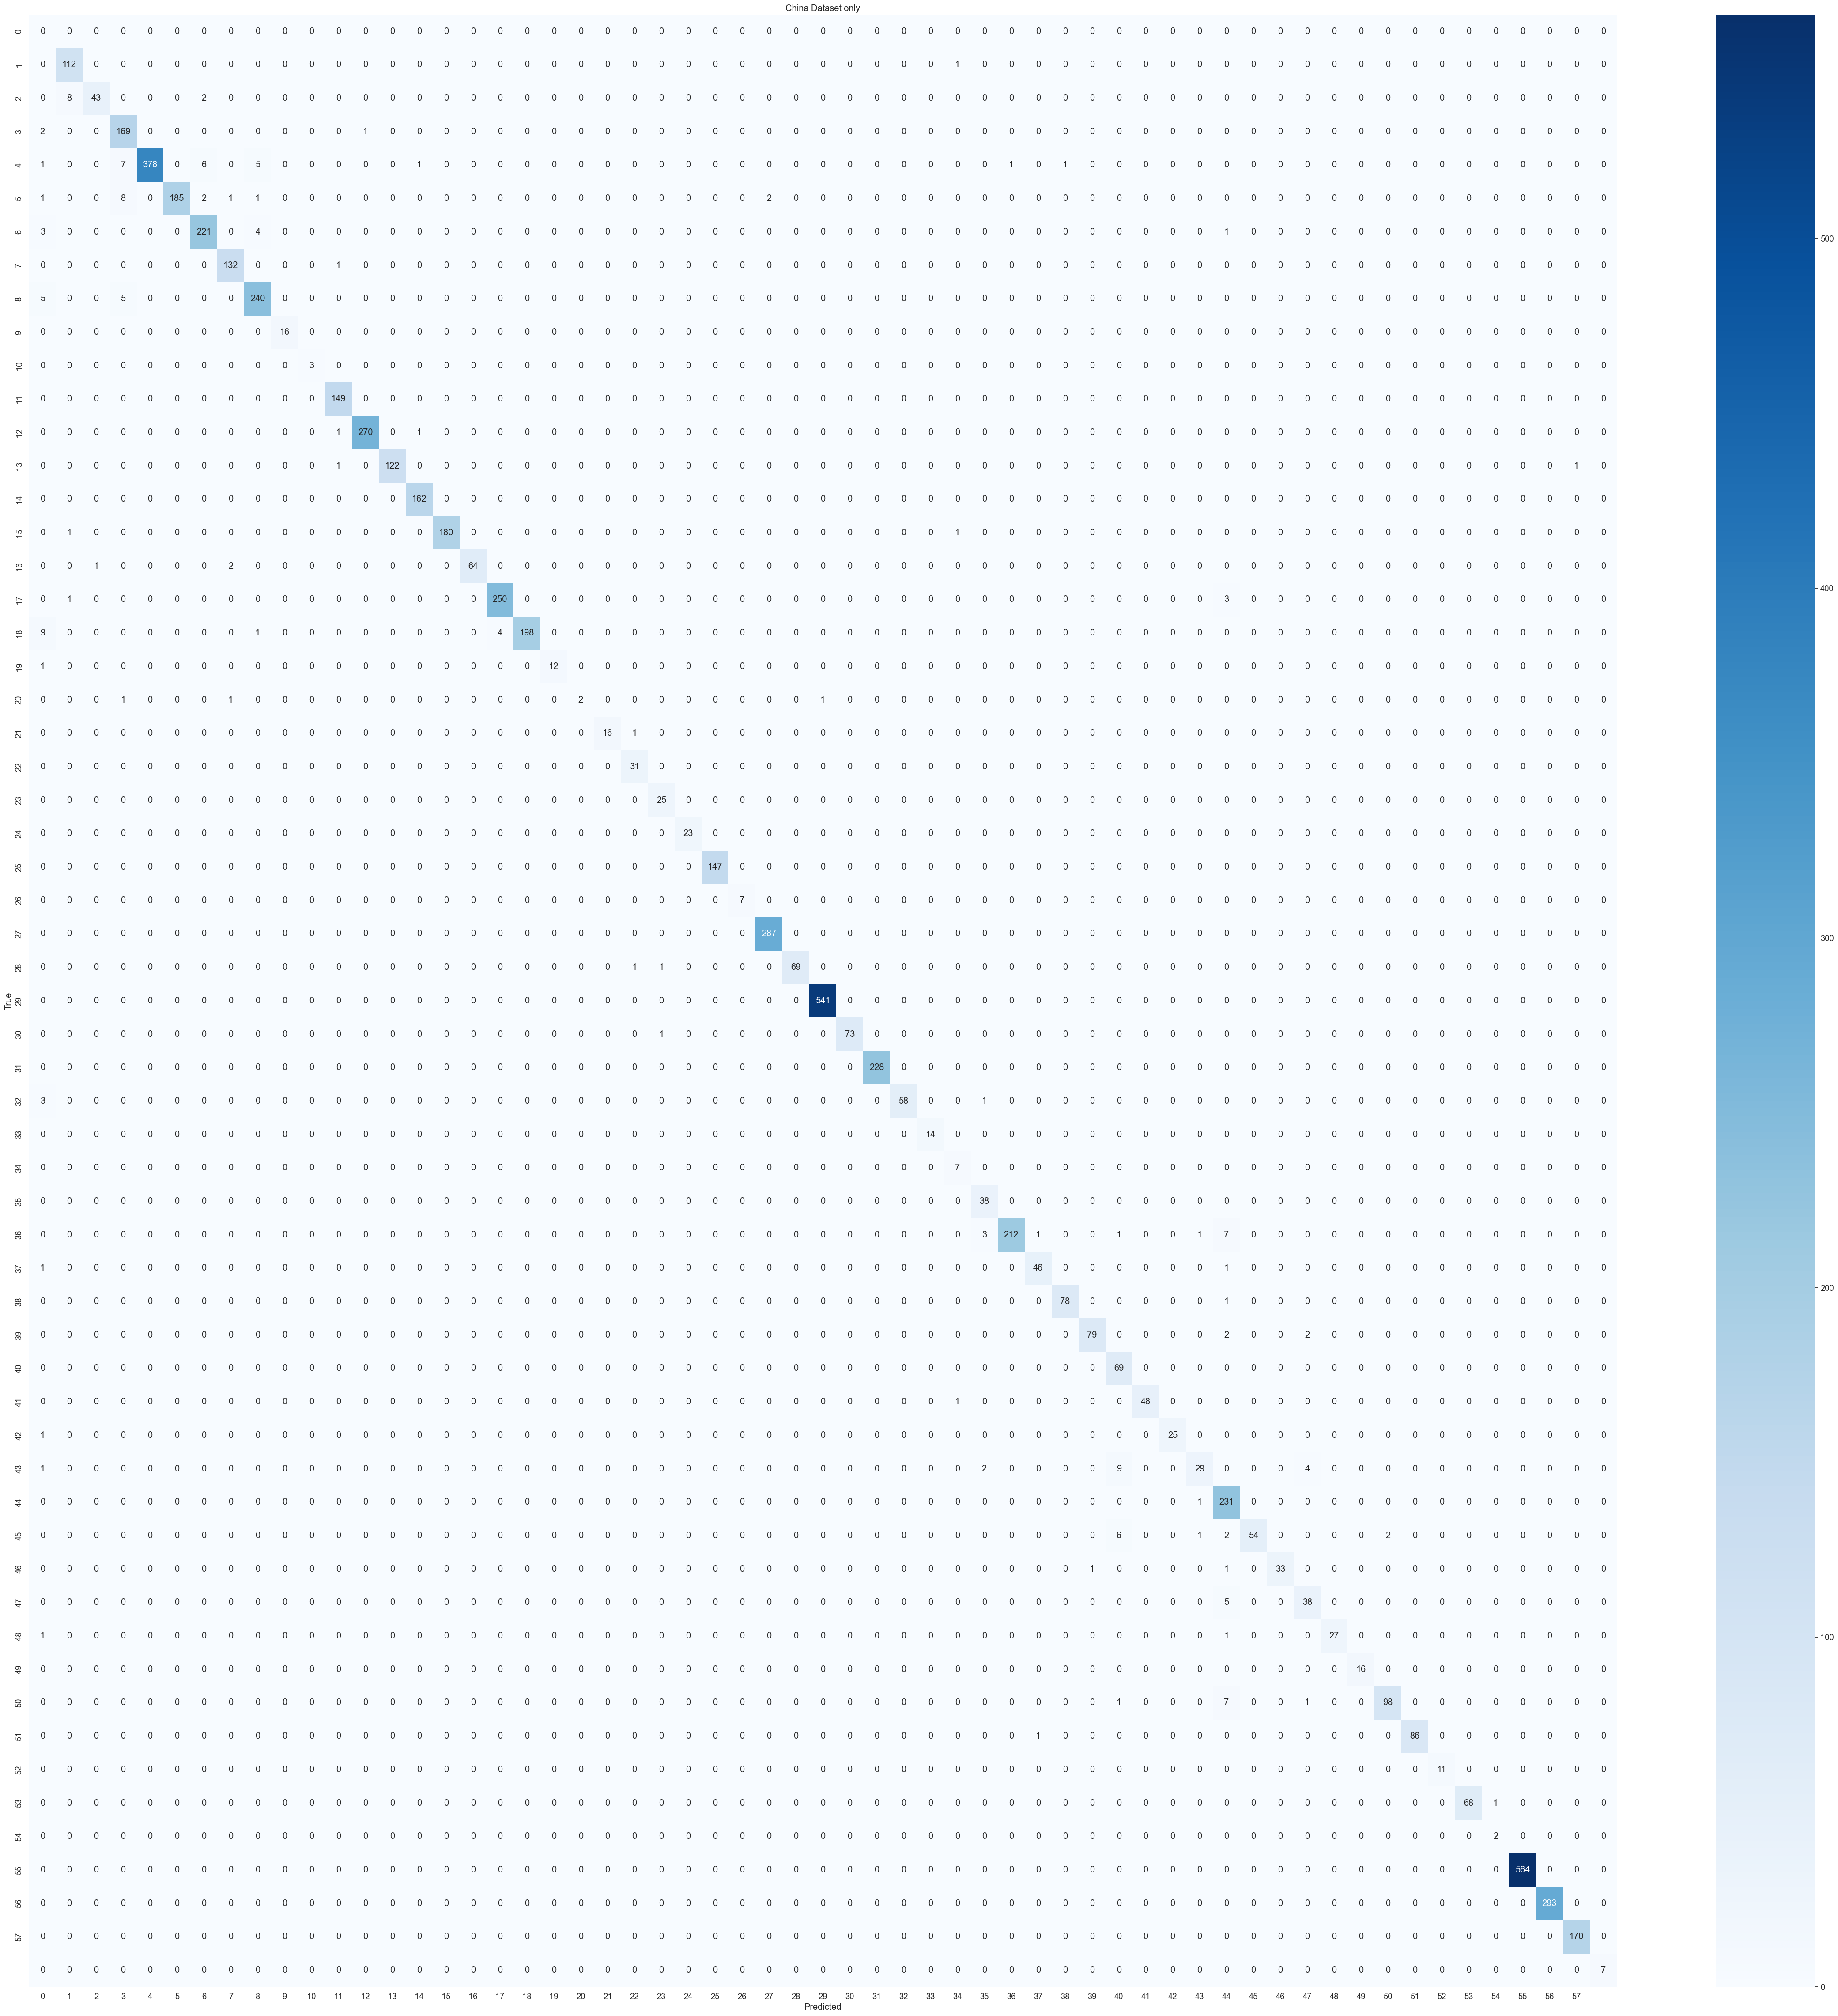

In [65]:
y_pred_58 = remap_labels(y_pred, merged_class_mapping, china_classes)
y_true_58 = remap_labels(y_true, merged_class_mapping, china_classes)
print("Confusion Matrix:")
plot_confusion_matrix(y_true_58, y_pred_58, 58, title='China Dataset only')

Evaluate using only india dataset:

In [93]:
india_test_label = remap_labels(india_test_label, india_classes, merged_class_mapping)
india_test_label = to_categorical(india_test_label, 106)

In [94]:
model = models.load_model("traffic_sign_model")
y_pred = model.predict(india_test_data)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(india_test_label, axis=1)
print(len(np.unique(y_true)))
print_metrics(y_true, y_pred)

497/497 [==============================] - 11s 21ms/step
18
Accuracy: 0.05032753842277652
Classification Report:
               precision    recall  f1-score   support

          13       1.00      0.00      0.01       286
          22       1.00      0.00      0.00       300
          24       0.77      0.34      0.48       316
          31       0.19      0.37      0.25       322
          33       0.55      0.12      0.20       305
          34       1.00      0.00      0.00       332
          40       0.05      0.02      0.03       302
          48       1.00      0.02      0.03       290
          49       0.85      0.22      0.35       293
          51       0.60      0.02      0.04       292
          52       1.00      0.00      0.00       297
          54       0.17      0.02      0.03       304
          55       0.18      0.10      0.13       870
          58       0.00      1.00      0.00         0
          65       1.00      0.00      0.00       288
          66       1.

Confusion Matrix:


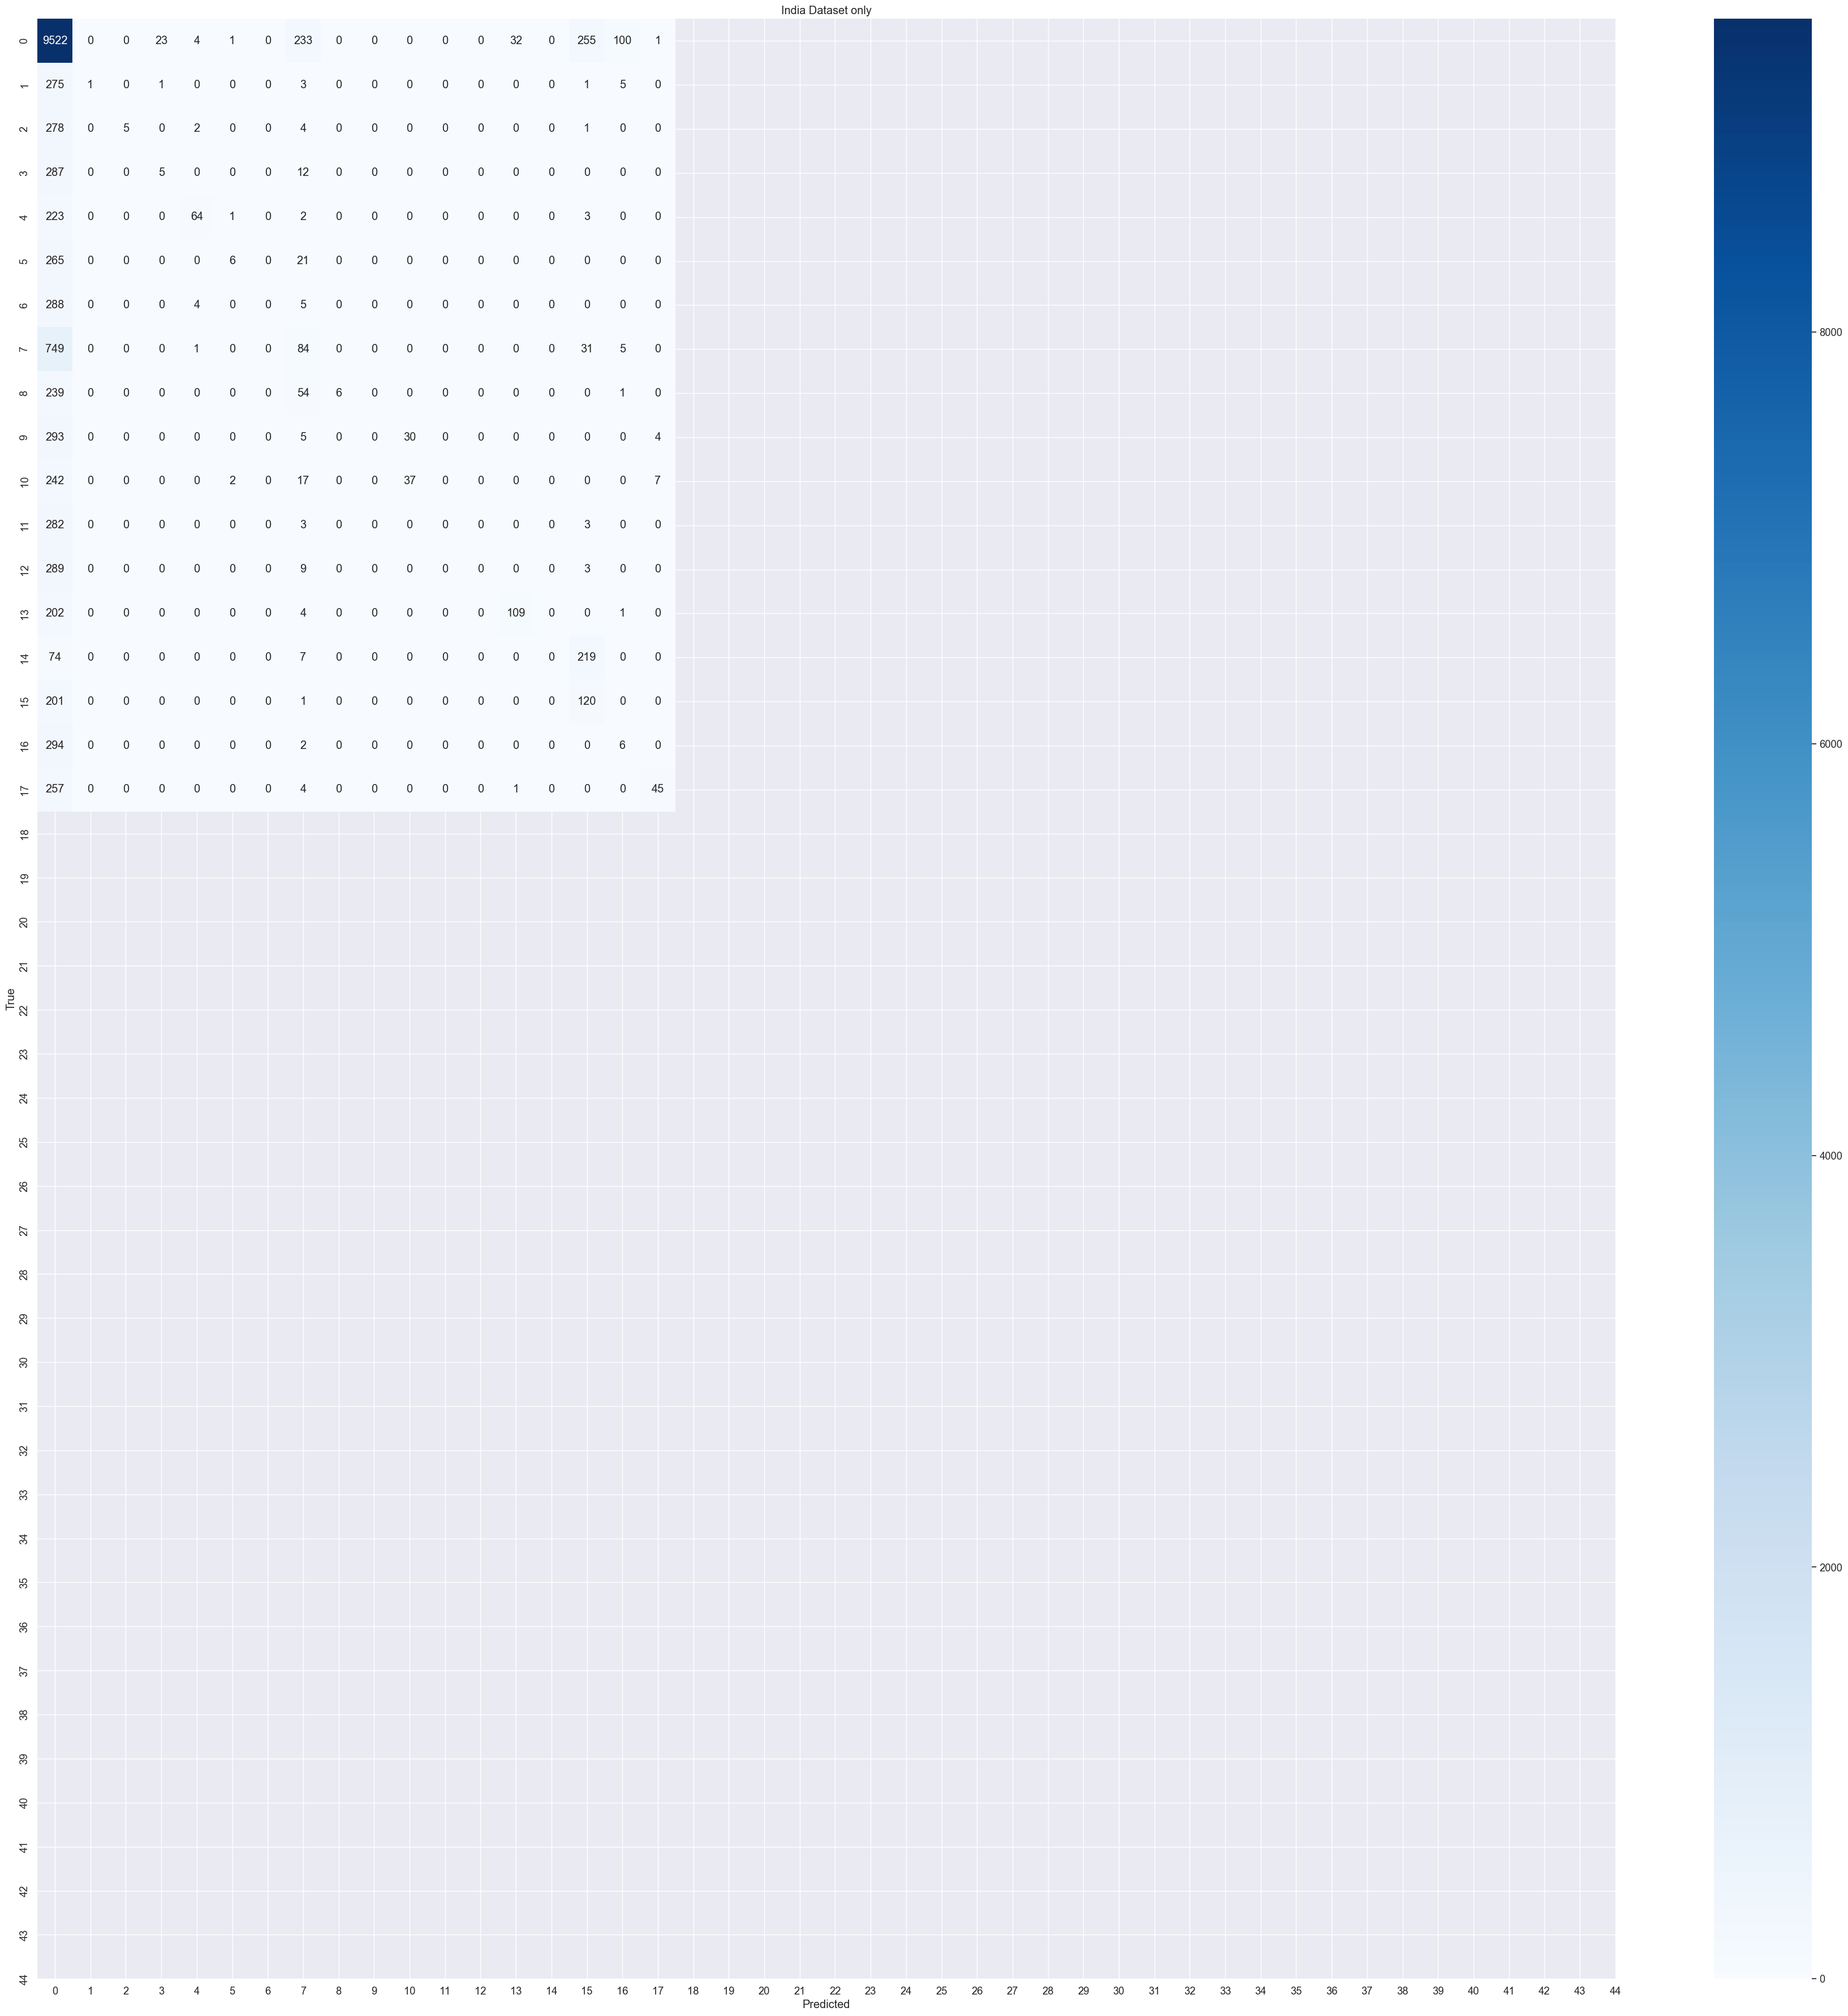

In [95]:
y_pred_45 = remap_labels(y_pred, merged_class_mapping, india_classes)
y_true_45 = remap_labels(y_true, merged_class_mapping, india_classes)
print("Confusion Matrix:")
plot_confusion_matrix(y_true_45, y_pred_45, 45, title='India Dataset only')

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Layer
from tensorflow.keras.models import Model

def resnet_identity_block(x, filters, kernel_size):
    """A ResNet identity block with two Conv2D layers."""
    fx = Conv2D(filters, kernel_size, padding='same')(x)
    fx = BatchNormalization()(fx)
    fx = Activation('relu')(fx)

    fx = Conv2D(filters, kernel_size, padding='same')(fx)
    fx = BatchNormalization()(fx)

    out = Add()([x, fx])  # Add() layer creates a residual connection
    out = Activation('relu')(out)
    return out

def resnet_conv_block(x, filters, kernel_size, strides):
    """A ResNet convolutional block with a Conv2D shortcut."""
    fx = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    fx = BatchNormalization()(fx)
    fx = Activation('relu')(fx)

    fx = Conv2D(filters, kernel_size, padding='same')(fx)
    fx = BatchNormalization()(fx)

    shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(x)
    shortcut = BatchNormalization()(shortcut)

    out = Add()([fx, shortcut])  # Shortcut connection
    out = Activation('relu')(out)
    return out

# Input layer
input_shape = (30, 30, 3)
inputs = Input(shape=input_shape)

# Initial Conv2D layer
x = Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)

# Residual blocks
x = resnet_conv_block(x, 64, (3, 3), strides=(1, 1))
x = resnet_identity_block(x, 64, (3, 3))
x = MaxPooling2D((2, 2))(x)

x = resnet_conv_block(x, 128, (3, 3), strides=(1, 1))
x = resnet_identity_block(x, 128, (3, 3))

# Finishing layers
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(103, activation='softmax')(x)  # Adjust the number of classes

# Create the model
model = Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "resnet_custom"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 30, 30, 3)]          0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 12, 12, 64)           9472      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_11 (Ba  (None, 12, 12, 64)           256       ['conv2d_12[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 12, 12, 64)           0         ['batch_normalizat